# 5 Modeling

## Table of Contents:

* [5.1 Introduction](#5.1_Introduction)
* [5.2 Import Packages](#5.2_Import_Packages)
* [5.3 Load the Data](#5.3_Load_the_Data)
* [5.4 Random Forest Classifier](#5.4_Random_Forest_Classifier)
* [5.5 AdaBoost](#5.5_AdaBoost)
* [5.6 Gradient Boost](#5.6_Gradient_Boost)
* [5.7 XG Boost](#5.7_XG_Boost)
* [5.8 Hyperparameter Tuning](#5.8_Hyperparameter_Tuning)
* [5.9 Evaluating Model Performance](#5.9_Evaluating_Model_Performance)
    * [Table of Results](#Table)
    * [Feature Importance](#Feature)
* [5.10 Summary and Next Steps](#5.10_Summary_and_Next_Steps)

## 5.1 Introduction<a id='5.1_Introduction'></a>

In our previous notebook (Preprocessing and Training Data Development), we resampled our datasets to achieve equal representation from each participant (pid 1 through 13) and from each binary class (TAC < 0.08 and TAC >= 0.08). Our final datasets had over 10k rows and over 280 features, with a 50/50 split between binary classes. We conducted a 70/30 train/test split, and used sklearn's StandardScaler to scale our inputs.

In this notebook, we will model our data, to see if we could reliably predict whether someone is legally sober (blood alcohol content < 8%) or legally drunk (blood alcohol content >= 8%) using our features derived from the cellphone accelerometer data. The authors of the original dataset (http://ceur-ws.org/Vol-2429/paper6.pdf, Killian, Passino,  Nandi, Madden, and Clapp) found that random forest performed the best, achieving an __accuracy of 77.5%__. This will serve as a baseline for us.

In this notebook we will do the following:
1. Apply 4 different models to the dataset: 
   * Random Forest Classifier
   * AdaBoost Classifier
   * GradientBoosting Classifier
   * XG Boost Classifier
2. Conduct hyperparameter tuning with 5-fold cross validation.
3. Evaluate each model's performance based on metrics including, but not limited to: accuracy, precision, recall, and F1-score. From the evaluation, we can identify which model is best for the dataset. In addition to the performance metrics, considerations for selecting the final model will include factors such as computational complexity and scalability.

## 5.2 Import Packages<a id='5.2_Import_Packages'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import time
import random

%matplotlib inline
import plotly.graph_objects as go
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

import xgboost as xgb

## 5.3 Load the Data<a id='5.3_Load_the_Data'></a>

In [2]:
# change directories to where the processed data is located.

path = 'D:\Documents\Springboard\Capstone 2 - heavy drinking project\data'
os.chdir(path)
os.getcwd()

'D:\\Documents\\Springboard\\Capstone 2 - heavy drinking project\\data'

In [3]:
#Note, the index column gets loaded as its own column, 'Unnamed: 0'
#We should remove it as to not have it included with our features.

X_train = pd.read_csv('X_train.csv').drop(columns=['Unnamed: 0'])
X_test = pd.read_csv('X_test.csv').drop(columns=['Unnamed: 0'])
y_train = pd.read_csv('y_train.csv')
y_test =pd.read_csv('y_test.csv')

X_train_tma = pd.read_csv('X_train_tma.csv').drop(columns=['Unnamed: 0'])
X_test_tma = pd.read_csv('X_test_tma.csv').drop(columns=['Unnamed: 0'])
y_train_tma =pd.read_csv('y_train_tma.csv')
y_test_tma = pd.read_csv('y_test_tma.csv')

In [4]:
#scale the raw/interpolated data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
#scale the triangular-moving-average smoothed data
scaler_t = StandardScaler()
scaler_t.fit(X_train_tma)
X_train_scaled_tma = scaler_t.transform(X_train_tma)
X_test_scaled_tma = scaler_t.transform(X_test_tma)

Our dependent variable (y) is a continuous variable. To properly utilize binary classification, we need to convert our dependent variable into binary classes. We define blood alcohol content (BAC) of >= 8% as 1 and BAC of <8% as 0.

In [6]:
#convert y_train and y_test from continuous variable to binary class. Do the same for _tma.
#here we define 1 as legally drunk and 0 as legally sober.

y_train.order_3[y_train.order_3 >= 0.08] = 1
y_train.order_3[y_train.order_3 < 0.08] = 0
y_train = y_train.order_3.astype('int32').to_numpy()

y_test.order_3[y_test.order_3 >= 0.08] = 1
y_test.order_3[y_test.order_3 < 0.08] = 0
y_test = y_test.order_3.astype('int32').to_numpy()


y_train_tma.tma[y_train_tma.tma >= 0.08] = 1
y_train_tma.tma[y_train_tma.tma < 0.08] = 0
y_train_tma = y_train_tma.tma.astype('int32').to_numpy()

y_test_tma.tma[y_test_tma.tma >= 0.08] = 1
y_test_tma.tma[y_test_tma.tma < 0.08] = 0
y_test_tma = y_test_tma.tma.astype('int32').to_numpy()

<ipython-input-6-2d567ae4f393>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.order_3[y_train.order_3 >= 0.08] = 1
<ipython-input-6-2d567ae4f393>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.order_3[y_train.order_3 < 0.08] = 0
<ipython-input-6-2d567ae4f393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.order_3[y_test.order_3 >= 0.08] = 1
<ipython-input-6-2d567ae4f393>:9: SettingWithCopyWarning: 
A value 

Our data is now ready for some modeling with classifiers!

## 5.4 Random Forest Classifier<a id='5.4_Random_Forest_Classifier'></a>

In the paper by Killian, et al., the RF Classifier was shown to be their best classifier, with an accuracy of 77.5%. We will start off with the RF Classifier as our baseline. We begin by modeling the raw/interpolate dataset and calculating some evaluation metrics. Afterwards, we repeat the same process for the tma-smoothed data.

In [7]:
start_time = time.time()

clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Random Forest, raw/interpolate data: Accuracy=%.3f' % (ac))
print('Random Forest, raw/interpolate data: f1-score=%.3f' % (f1))
print('Random Forest, raw/interpolate data: precision=%.3f' % (pr))
print('Random Forest, raw/interpolate data: recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time:', time.time() - start_time)

Random Forest, raw/interpolate data: Accuracy=0.753
Random Forest, raw/interpolate data: f1-score=0.748
Random Forest, raw/interpolate data: precision=0.718
Random Forest, raw/interpolate data: recall=0.873

Confusion Matrix without Normalization
[[ 802  493]
 [ 182 1256]]

Confusion Matrix with Normalization
[[0.62 0.38]
 [0.13 0.87]]

Total Time: 2.5259361267089844


Immediately we see with an out-of-the-box RF Classifier (prior to hyperparameter tuning) we get an accuracy of 75.3%, slightly lower than in the Killian, et al. paper. 

We also get to see our F1-score, precision, and recall, which are each defined as:
 * F1-score = 2 * (precision * recall) / (precision + recall)
 * precision = TP / (TP + FP)
 * recall = TP / (TP + FN)
    
We are more interested in minimizing our False Negatives (i.e. predicting someone as sober when they are drunk) moreso than minimizing our False Positives (i.e. predicting they are drunk when they are actually sober).This is because it is more important that our model can detect when someone is drunk, and can send a "just-in-time adaptive intervention" to discourage further drinking. While having several "false alarms" is not ideal as users could become annoyed or desensitized to the alerts, the risk of loss is greater if a user were to get involved in heavy drinking and not receive any intervention.

Because we want to minimize our False Negatives (FN), "recall" is a metric that is particularly important to us. We want to maximize "recall". Note that "recall" is also referred to as "true positive rate", "sensitivity", or "hit rate".

We can visually see how our model fares by looking at the ROC curve (which plots TPR against FPR) and checking the area under the curve, and similarly by looking at the precision-recall curve (which plots precision against TPR/recall). 

FPR: 0.38
TPR: 0.87


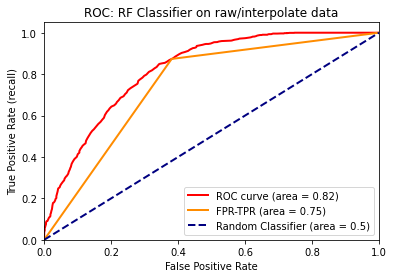

In [8]:
#Receiver Operating Characteristic (ROC), returns false positive rate (x-axis), true positive rate (y-axis)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('FPR:',fpr[1].round(2))
print('TPR:',tpr[1].round(2))

lr_probs = y_pred_prob[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_roc_auc = auc(lr_fpr, lr_tpr)

lw = 2
plt.plot(lr_fpr, lr_tpr, linestyle='-', color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='FPR-TPR (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Classifier (area = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC: RF Classifier on raw/interpolate data')
plt.legend(loc="lower right")
plt.show()

Average precision-recall score: 0.69


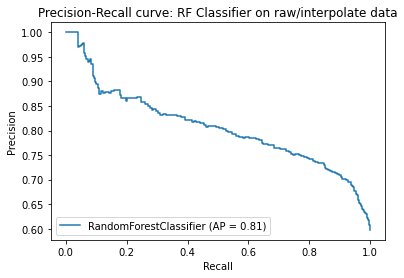

In [9]:
#We can also look at the precision/recall curve.
#Note: average_precision (AP) summarizes a precision-recall curve as the weighted mean of precisions 
# achieved at each threshold, with the increase in recall from the previous threshold used as the weight.
# See the sklearn documentation for more info.

average_precision = average_precision_score(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, X_test_scaled, y_test)
_=disp.ax_.set_title('Precision-Recall curve: RF Classifier on raw/interpolate data')

We've taken a look at the raw/interpolated data. Now let's see how our tma-smoothed (smoothed by triangular moving average) dataset fares with a out-of-the-box RF classifier.

In [10]:
start_time = time.time()

clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled_tma, y_train_tma)
y_pred = model_res.predict(X_test_scaled_tma)
y_pred_prob = model_res.predict_proba(X_test_scaled_tma)
ac = accuracy_score(y_test_tma, y_pred)

f1 = f1_score(y_test_tma, y_pred, average='weighted')
pr = precision_score(y_test_tma, y_pred)
re = recall_score(y_test_tma, y_pred)
cm = confusion_matrix(y_test_tma, y_pred)

print('Random Forest, tma-smoothed data: Accuracy=%.3f' % (ac))
print('Random Forest, tma-smoothed data: f1-score=%.3f' % (f1))
print('Random Forest, tma-smoothed data: precision=%.3f' % (pr))
print('Random Forest, tma-smoothed data: recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time:', time.time() - start_time)

Random Forest, tma-smoothed data: Accuracy=0.793
Random Forest, tma-smoothed data: f1-score=0.791
Random Forest, tma-smoothed data: precision=0.742
Random Forest, tma-smoothed data: recall=0.903

Confusion Matrix without Normalization
[[ 968  449]
 [ 139 1290]]

Confusion Matrix with Normalization
[[0.68 0.32]
 [0.1  0.9 ]]

Total Time: 2.691802978515625


FPR: 0.32
TPR: 0.9


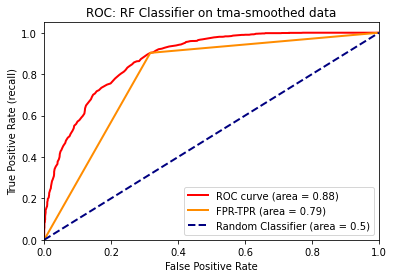

In [11]:
#Receiver Operating Characteristic (ROC), returns false positive rate (x-axis), true positive rate (y-axis)
fpr, tpr, _ = roc_curve(y_test_tma, y_pred)
roc_auc = auc(fpr, tpr)
print('FPR:',fpr[1].round(2))
print('TPR:',tpr[1].round(2))

lr_probs = y_pred_prob[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test_tma, lr_probs)
lr_roc_auc = auc(lr_fpr, lr_tpr)

lw = 2
plt.plot(lr_fpr, lr_tpr, linestyle='-', color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='FPR-TPR (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Classifier (area = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC: RF Classifier on tma-smoothed data')
plt.legend(loc="lower right")
plt.show()

Average precision-recall score: 0.72


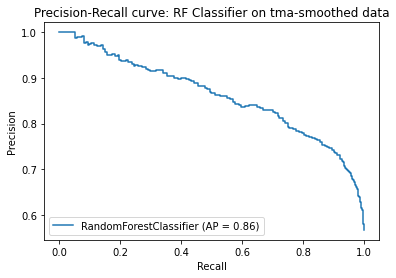

In [12]:
average_precision = average_precision_score(y_test_tma, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, X_test_scaled_tma, y_test_tma)
_=disp.ax_.set_title('Precision-Recall curve: RF Classifier on tma-smoothed data')

Immediately we see an improvement with the tma-smoothed data. The accuracy, F1-score, precision, recall, and AUC all perform better than the same metrics for the raw/interpolated data. Accuracy is at 79.3%, immediately better than the results from the Killian, et al. paper!

We can only imagine even better results with some hyperparameter tuning. But before that, we should take a look at a few more out-of-the-box models.

## 5.5 AdaBoost<a id='5.5_AdaBoost'></a>

AdaBoost, or Adaptive Boosting, is a boosting ensemble method. This differs from Random Forest in which RF uses bagging (training many individual models in parallel) and AdaBoost uses boosting (training models sequntially, where each successive model learns from the mistakes of the previous model).

Both are ensemble methods using decision trees, but differ in their mechanism of how those trees are trained and weighted. However, in their implementation, the code is nearly identical.

In [13]:
#raw/interpolate data

start_time = time.time()

clf = AdaBoostClassifier(n_estimators=300, random_state = 1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('AdaBoost, raw/interpolate data: Accuracy=%.3f' % (ac))
print('AdaBoost, raw/interpolate data: f1-score=%.3f' % (f1))
print('AdaBoost, raw/interpolate data: precision=%.3f' % (pr))
print('AdaBoost, raw/interpolate data: recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time:', time.time() - start_time)

AdaBoost, raw/interpolate data: Accuracy=0.680
AdaBoost, raw/interpolate data: f1-score=0.679
AdaBoost, raw/interpolate data: precision=0.680
AdaBoost, raw/interpolate data: recall=0.741

Confusion Matrix without Normalization
[[ 793  502]
 [ 372 1066]]

Confusion Matrix with Normalization
[[0.61 0.39]
 [0.26 0.74]]

Total Time: 34.95333290100098


FPR: 0.39
TPR: 0.74


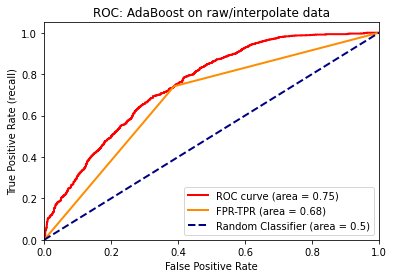

In [14]:
#Receiver Operating Characteristic (ROC), returns false positive rate (x-axis), true positive rate (y-axis)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('FPR:',fpr[1].round(2))
print('TPR:',tpr[1].round(2))

lr_probs = y_pred_prob[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_roc_auc = auc(lr_fpr, lr_tpr)

lw = 2
plt.plot(lr_fpr, lr_tpr, linestyle='-', color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='FPR-TPR (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Classifier (area = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC: AdaBoost on raw/interpolate data')
plt.legend(loc="lower right")
plt.show()

Average precision-recall score: 0.64


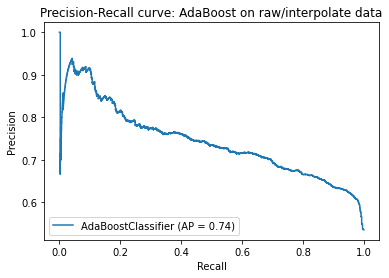

In [15]:
average_precision = average_precision_score(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, X_test_scaled, y_test)
_=disp.ax_.set_title('Precision-Recall curve: AdaBoost on raw/interpolate data')

In [16]:
#tma-smoothed data

start_time = time.time()

clf = AdaBoostClassifier(n_estimators=300, random_state = 1)
model_res = clf.fit(X_train_scaled_tma, y_train_tma)
y_pred = model_res.predict(X_test_scaled_tma)
y_pred_prob = model_res.predict_proba(X_test_scaled_tma)
ac = accuracy_score(y_test_tma, y_pred)

f1 = f1_score(y_test_tma, y_pred, average='weighted')
pr = precision_score(y_test_tma, y_pred)
re = recall_score(y_test_tma, y_pred)
cm = confusion_matrix(y_test_tma, y_pred)

print('AdaBoost, tma-smoothed data: Accuracy=%.3f' % (ac))
print('AdaBoost, tma-smoothed data: f1-score=%.3f' % (f1))
print('AdaBoost, tma-smoothed data: precision=%.3f' % (pr))
print('AdaBoost, tma-smoothed data: recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time:', time.time() - start_time)

AdaBoost, tma-smoothed data: Accuracy=0.711
AdaBoost, tma-smoothed data: f1-score=0.710
AdaBoost, tma-smoothed data: precision=0.694
AdaBoost, tma-smoothed data: recall=0.759

Confusion Matrix without Normalization
[[ 938  479]
 [ 344 1085]]

Confusion Matrix with Normalization
[[0.66 0.34]
 [0.24 0.76]]

Total Time: 35.27698349952698


FPR: 0.34
TPR: 0.76


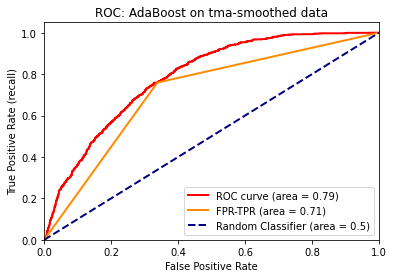

In [17]:
#Receiver Operating Characteristic (ROC), returns false positive rate (x-axis), true positive rate (y-axis)
fpr, tpr, _ = roc_curve(y_test_tma, y_pred)
roc_auc = auc(fpr, tpr)
print('FPR:',fpr[1].round(2))
print('TPR:',tpr[1].round(2))

lr_probs = y_pred_prob[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test_tma, lr_probs)
lr_roc_auc = auc(lr_fpr, lr_tpr)

lw = 2
plt.plot(lr_fpr, lr_tpr, linestyle='-', color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='FPR-TPR (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Classifier (area = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC: AdaBoost on tma-smoothed data')
plt.legend(loc="lower right")
plt.show()

Average precision-recall score: 0.65


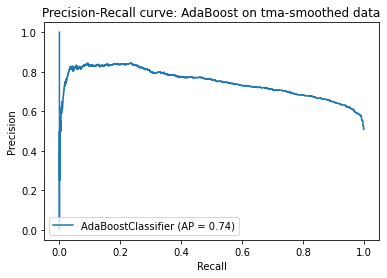

In [18]:
average_precision = average_precision_score(y_test_tma, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, X_test_scaled_tma, y_test_tma)
_=disp.ax_.set_title('Precision-Recall curve: AdaBoost on tma-smoothed data')

AdaBoost is performing even worse than Random Forest. Furthermore, it takes longer since each decision tree/model must be trained serially rather than in parallel. In this particular project, AdaBoost is not worth considering.

## 5.6 Gradient Boost<a id='5.6_Gradient_Boost'></a>

Like AdaBoost, Gradient Boost is a boosting ensemble method. However, instead of updating the weights of data points (as in AdaBoost), Gradient Boosting learns from the residual error directly. It's a nuanced difference, but worth looking into its performance in modeling our dataset.

In [19]:
#raw/interpolate data

start_time = time.time()

clf = GradientBoostingClassifier(n_estimators=300, random_state = 1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Gradient Boost, raw/interpolate data: Accuracy=%.3f' % (ac))
print('Gradient Boost, raw/interpolate data: f1-score=%.3f' % (f1))
print('Gradient Boost, raw/interpolate data: precision=%.3f' % (pr))
print('Gradient Boost, raw/interpolate data: recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time:', time.time() - start_time)

Gradient Boost, raw/interpolate data: Accuracy=0.739
Gradient Boost, raw/interpolate data: f1-score=0.737
Gradient Boost, raw/interpolate data: precision=0.719
Gradient Boost, raw/interpolate data: recall=0.830

Confusion Matrix without Normalization
[[ 828  467]
 [ 245 1193]]

Confusion Matrix with Normalization
[[0.64 0.36]
 [0.17 0.83]]

Total Time: 85.5750982761383


FPR: 0.36
TPR: 0.83


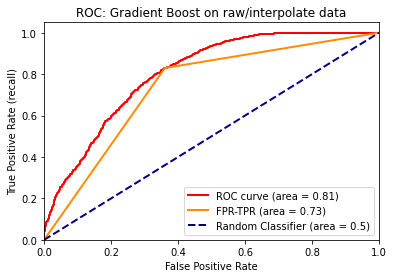

In [20]:
#Receiver Operating Characteristic (ROC), returns false positive rate (x-axis), true positive rate (y-axis)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('FPR:',fpr[1].round(2))
print('TPR:',tpr[1].round(2))

lr_probs = y_pred_prob[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_roc_auc = auc(lr_fpr, lr_tpr)

lw = 2
plt.plot(lr_fpr, lr_tpr, linestyle='-', color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='FPR-TPR (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Classifier (area = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC: Gradient Boost on raw/interpolate data')
plt.legend(loc="lower right")
plt.show()

Average precision-recall score: 0.69


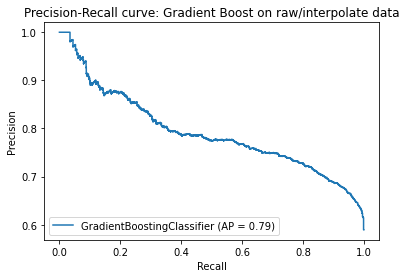

In [21]:
average_precision = average_precision_score(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, X_test_scaled, y_test)
_=disp.ax_.set_title('Precision-Recall curve: Gradient Boost on raw/interpolate data')

In [22]:
#tma-smoothed data

start_time = time.time()

clf = GradientBoostingClassifier(n_estimators=300, random_state = 1)
model_res = clf.fit(X_train_scaled_tma, y_train_tma)
y_pred = model_res.predict(X_test_scaled_tma)
y_pred_prob = model_res.predict_proba(X_test_scaled_tma)
ac = accuracy_score(y_test_tma, y_pred)

f1 = f1_score(y_test_tma, y_pred, average='weighted')
pr = precision_score(y_test_tma, y_pred)
re = recall_score(y_test_tma, y_pred)
cm = confusion_matrix(y_test_tma, y_pred)

print('Gradient Boost, tma-smoothed data: Accuracy=%.3f' % (ac))
print('Gradient Boost, tma-smoothed data: f1-score=%.3f' % (f1))
print('Gradient Boost, tma-smoothed data: precision=%.3f' % (pr))
print('Gradient Boost, tma-smoothed data: recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time:', time.time() - start_time)

Gradient Boost, tma-smoothed data: Accuracy=0.762
Gradient Boost, tma-smoothed data: f1-score=0.760
Gradient Boost, tma-smoothed data: precision=0.723
Gradient Boost, tma-smoothed data: recall=0.853

Confusion Matrix without Normalization
[[ 951  466]
 [ 210 1219]]

Confusion Matrix with Normalization
[[0.67 0.33]
 [0.15 0.85]]

Total Time: 83.25604271888733


FPR: 0.33
TPR: 0.85


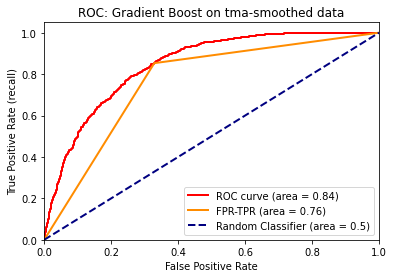

In [23]:
#Receiver Operating Characteristic (ROC), returns false positive rate (x-axis), true positive rate (y-axis)
fpr, tpr, _ = roc_curve(y_test_tma, y_pred)
roc_auc = auc(fpr, tpr)
print('FPR:',fpr[1].round(2))
print('TPR:',tpr[1].round(2))

lr_probs = y_pred_prob[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test_tma, lr_probs)
lr_roc_auc = auc(lr_fpr, lr_tpr)

lw = 2
plt.plot(lr_fpr, lr_tpr, linestyle='-', color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='FPR-TPR (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Classifier (area = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC: Gradient Boost on tma-smoothed data')
plt.legend(loc="lower right")
plt.show()

Average precision-recall score: 0.69


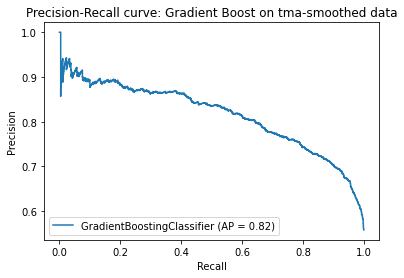

In [24]:
average_precision = average_precision_score(y_test_tma, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, X_test_scaled_tma, y_test_tma)
_=disp.ax_.set_title('Precision-Recall curve: Gradient Boost on tma-smoothed data')

We see that Gradient Boost performs better than AdaBoost. The tma-smoothed data models with an accuracy of 76.2% and recall of 85.3% for Gradient Boost, while only 71.1% accuracy and 75.9% recall for AdaBoost. However, it still pales in comparison to Random Forest, which has an accuracy of 79.3% and recall of 90.3% when modeling on the tma-smoothed data.

## 5.7 XG Boost<a id='5.7_XG_Boost'></a>

"Extreme Gradient Boosting", or XG Boost, is another ensemble method, following the same principle as Gradient Boost. However, XGB uses a more regularized model formalization to control for over-fitting, resulting in improved performance. XG Boost also has several important performance enhancements in its implementation, making it faster and than Gradient Boost, and also allowing it to utilize less memory. In many ways, it is the "gold standard" of decision tree modeling at this time, and is worth investigating.

In [25]:
#for raw/interpolate data

start_time = time.time()

clf = xgb.XGBClassifier(seed=1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('XGBoost, raw/interpolate data: Accuracy=%.3f' % (ac))
print('XGBoost, raw/interpolate data: f1-score=%.3f' % (f1))
print('XGBoost, raw/interpolate data: precision=%.3f' % (pr))
print('XGBoost, raw/interpolate data: recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time:', time.time() - start_time)

C:\Users\grace\anaconda3\envs\TestEnv9\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost, raw/interpolate data: Accuracy=0.864
XGBoost, raw/interpolate data: f1-score=0.863
XGBoost, raw/interpolate data: precision=0.836
XGBoost, raw/interpolate data: recall=0.922

Confusion Matrix without Normalization
[[1035  260]
 [ 112 1326]]

Confusion Matrix with Normalization
[[0.8  0.2 ]
 [0.08 0.92]]

Total Time: 4.655405759811401


FPR: 0.2
TPR: 0.92


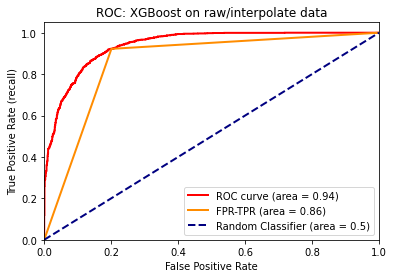

In [26]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('FPR:',fpr[1].round(2))
print('TPR:',tpr[1].round(2))

lr_probs = y_pred_prob[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_roc_auc = auc(lr_fpr, lr_tpr)

lw = 2
plt.plot(lr_fpr, lr_tpr, linestyle='-', color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='FPR-TPR (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Classifier (area = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC: XGBoost on raw/interpolate data')
plt.legend(loc="lower right")
plt.show()

Average precision-recall score: 0.81


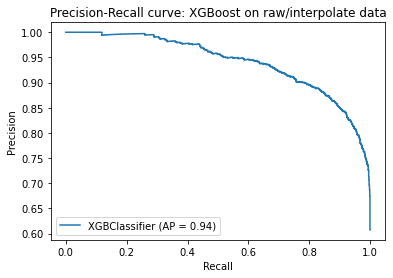

In [27]:
average_precision = average_precision_score(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, X_test_scaled, y_test)
_=disp.ax_.set_title('Precision-Recall curve: XGBoost on raw/interpolate data')

In [28]:
#tma-smoothed data

start_time = time.time()

clf = xgb.XGBClassifier(seed=1)
model_res = clf.fit(X_train_scaled_tma, y_train_tma)
y_pred = model_res.predict(X_test_scaled_tma)
y_pred_prob = model_res.predict_proba(X_test_scaled_tma)
ac = accuracy_score(y_test_tma, y_pred)

f1 = f1_score(y_test_tma, y_pred, average='weighted')
pr = precision_score(y_test_tma, y_pred)
re = recall_score(y_test_tma, y_pred)
cm = confusion_matrix(y_test_tma, y_pred)

print('XGBoost, tma-smoothed data: Accuracy=%.3f' % (ac))
print('XGBoost, tma-smoothed data: f1-score=%.3f' % (f1))
print('XGBoost, tma-smoothed data: precision=%.3f' % (pr))
print('XGBoost, tma-smoothed data: recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time:', time.time() - start_time)

C:\Users\grace\anaconda3\envs\TestEnv9\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost, tma-smoothed data: Accuracy=0.894
XGBoost, tma-smoothed data: f1-score=0.893
XGBoost, tma-smoothed data: precision=0.875
XGBoost, tma-smoothed data: recall=0.920

Confusion Matrix without Normalization
[[1229  188]
 [ 115 1314]]

Confusion Matrix with Normalization
[[0.87 0.13]
 [0.08 0.92]]

Total Time: 3.6408894062042236


FPR: 0.13
TPR: 0.92


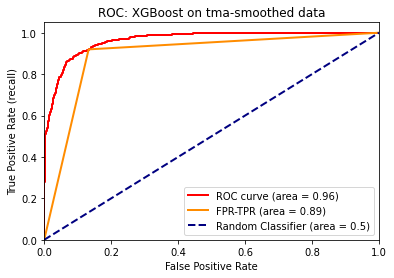

In [29]:
fpr, tpr, _ = roc_curve(y_test_tma, y_pred)
roc_auc = auc(fpr, tpr)
print('FPR:',fpr[1].round(2))
print('TPR:',tpr[1].round(2))

lr_probs = y_pred_prob[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test_tma, lr_probs)
lr_roc_auc = auc(lr_fpr, lr_tpr)

lw = 2
plt.plot(lr_fpr, lr_tpr, linestyle='-', color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='FPR-TPR (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Classifier (area = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC: XGBoost on tma-smoothed data')
plt.legend(loc="lower right")
plt.show()

Average precision-recall score: 0.84


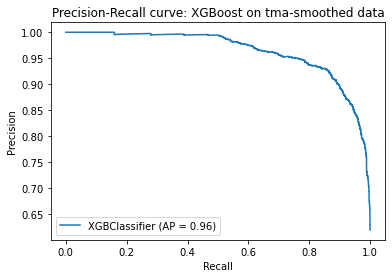

In [30]:
average_precision = average_precision_score(y_test_tma, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, X_test_scaled_tma, y_test_tma)
_=disp.ax_.set_title('Precision-Recall curve: XGBoost on tma-smoothed data')

The results are phenomenal! XGBoost on both the raw/interpolate data and the tma-smoothed data outperforms all of the other models in all measured metrics. Below is a summary of the measured metrics for Random Forest (our previously best out-of-the-box model) and XGBoost (the new king amongst our models). We will look only at the results from the tma-smoothed data, as that has consistently surpassed in accuracy over the raw/interpolate data.

Random Forest, tma-smoothed data: 
* __Accuracy=0.793__
* f1-score=0.791
* precision=0.742
* __recall=0.903__
* ROC AUC = 0.88
* Average precision-recall score: 0.72

XGBoost, tma-smoothed data: 
* __Accuracy=0.894__
* f1-score=0.893
* precision=0.875
* __recall=0.920__
* ROC AUC = 0.96
* Average precision-recall score: 0.84

It is also worth noting that XGBoost has an ROC AUC of 0.96, which is incredibly close to 1.00, indicating that it is overall a better performing model than all of the others, allowing it to achiever greater TPR while maintaining low FPR.

## 5.8 Hyperparameter Tuning<a id='5.8_Hyperparameter_Tuning'></a>

The next step in our notebook is to optimize our model by tuning its hyperparameters. We saw in the previous sections that the RF and XGBoost classifiers on tma-smoothed data performed best. As a result, we will conduct hyperparameter tuning on both of these models. 

To ensure proper optimization, we will conduct a 5-fold cross validation on our training data (we do not touch the test data until the very end). This essentially simulates a 80/20 train/test split on the training dataset, which will control for potential overfitting on the training data for any given set of parameters.

When tuning our parameters, we will use RandomizedSearchCV rather than GridSearchCV. Randomized Searches have been shown to perform as well or better than Grid Searches, and importantly utilizes fewer resources (time, memory) than Grid Search.

In [78]:
#RF Classifier

#parameter grid to search for best param combination
n_estimators = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
max_depth = [int(x) for x in np.linspace(start=3, stop=30, num = 10)]
min_samples_split = [int(n) for n in np.logspace(start=1, stop=2, num=10)]
min_samples_leaf = [int(n) for n in np.logspace(start=0, stop=1, num=4)]

param_grid = dict(n_estimators = n_estimators, 
                  max_depth = max_depth,  
                  min_samples_split = min_samples_split, 
                  min_samples_leaf = min_samples_leaf)

#create the model
clf = RandomForestClassifier(random_state=1)

#search 100 different combinations (n_iter=100) and use all processors (n_jobs=-1)
rf_cv= RandomizedSearchCV(estimator = clf, 
                          param_distributions = param_grid,
                          cv = 5,
                          n_iter = 100, 
                          random_state=1, 
                          n_jobs = -1,
                         )

#fit against the tma-smoothed data
rf_cv.fit(X_train_scaled_tma, y_train_tma)

print("Best Score:", str(rf_cv.best_score_))
print("Best Parameters:", str(rf_cv.best_params_))

Best Score: 0.7634036144578313
Best Parameters: {'n_estimators': 69, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_depth': 21}


For our RF Classifier, we get that the Best Parameters are: {'n_estimators': 69, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_depth': 21}

Now let's take a look at XGBoost.

In [31]:
# XGBoost Classifier

#parameter grid to search for best param combination
n_estimators = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
max_depth = [int(x) for x in np.linspace(start=3, stop=30, num = 10)]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5]

param_grid = dict(n_estimators = n_estimators, 
                  max_depth = max_depth,  
                  learning_rate = learning_rate)

#create the model
clf_xgb = xgb.XGBClassifier(seed=1)

#search 100 different combinations (n_iter=100) and use all processors (n_jobs=-1)
xgb_cv= RandomizedSearchCV(estimator = clf_xgb, 
                          param_distributions = param_grid,
                          cv = 5,
                          n_iter = 100, 
                          n_jobs = -1,
                         )

#fit against the tma-smoothed data
xgb_cv.fit(X_train_scaled_tma, y_train_tma)

print("Best Score:", str(xgb_cv.best_score_))
print("Best Parameters:", str(xgb_cv.best_params_))

C:\Users\grace\anaconda3\envs\TestEnv9\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:12:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Score: 0.9031626506024096
Best Parameters: {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.1}


For our XGBoost Classifier, we get that the Best Parameters are: {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.1}

Using these tuned hyperparameters, we will take our optimized models and test them against the test set. Compared to our earlier out-of-the-box models, these current models with optimized hyperparameters should be expected to increase our modeling accuracy and overall performance (including precision and recall). 

## 5.9 Evaluating Model Performance<a id='5.9_Evaluating_Model_Performance'></a>

In this step, we model our dataset using RF Classifier and XG Boost Classifier with tuned hyperparameters. We will evaluate each model's performance based on the following: accuracy, precision, recall, F1-score, ROC AUC, and average precision-recall score. Due to interested in minimizing False Negatives, we place greater importance on higher recall score. 

We will also time how long it takes each model to analyze the dataset. It is important to consider the feasibility of running a system that can model and predict a person's phone accelerometer data in real time. Something that can model quickly will be more practical in generating results in real time and also less power hungry for the cell phone.

In [31]:
# RF Classifier
start_time = time.time()

# Best Parameters: {'n_estimators': 69, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_depth': 21}

clf = RandomForestClassifier(n_estimators=69, 
                             min_samples_split = 12, 
                             min_samples_leaf= 1, 
                             max_depth = 21,
                             random_state = 1,
                             n_jobs=-1
                            )
model_res = clf.fit(X_train_scaled_tma, y_train_tma)
y_pred = model_res.predict(X_test_scaled_tma)
y_pred_prob = model_res.predict_proba(X_test_scaled_tma)
ac = accuracy_score(y_test_tma, y_pred)

f1 = f1_score(y_test_tma, y_pred, average='weighted')
pr = precision_score(y_test_tma, y_pred)
re = recall_score(y_test_tma, y_pred)
cm = confusion_matrix(y_test_tma, y_pred)

print('Random Forest, tma-smoothed data: Accuracy=%.3f' % (ac))
print('Random Forest, tma-smoothed data: f1-score=%.3f' % (f1))
print('Random Forest, tma-smoothed data: precision=%.3f' % (pr))
print('Random Forest, tma-smoothed data: recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))
print()
print('Total Time for RFC:', time.time() - start_time)

Random Forest, tma-smoothed data: Accuracy=0.768
Random Forest, tma-smoothed data: f1-score=0.765
Random Forest, tma-smoothed data: precision=0.722
Random Forest, tma-smoothed data: recall=0.874

Confusion Matrix without Normalization
[[ 937  480]
 [ 180 1249]]

Confusion Matrix with Normalization
[[0.66 0.34]
 [0.13 0.87]]

Total Time for RFC: 0.547297477722168


FPR: 0.34
TPR: 0.87


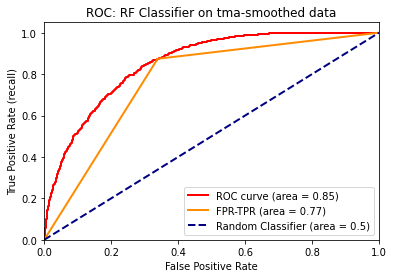

In [32]:
fpr, tpr, _ = roc_curve(y_test_tma, y_pred)
roc_auc = auc(fpr, tpr)
print('FPR:',fpr[1].round(2))
print('TPR:',tpr[1].round(2))

lr_probs = y_pred_prob[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test_tma, lr_probs)
lr_roc_auc = auc(lr_fpr, lr_tpr)

lw = 2
plt.plot(lr_fpr, lr_tpr, linestyle='-', color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='FPR-TPR (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Classifier (area = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC: RF Classifier on tma-smoothed data')
plt.legend(loc="lower right")
plt.show()

Average precision-recall score: 0.69


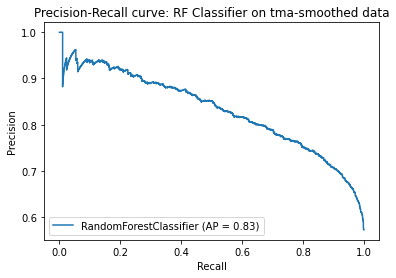

In [33]:
average_precision = average_precision_score(y_test_tma, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, X_test_scaled_tma, y_test_tma)
_=disp.ax_.set_title('Precision-Recall curve: RF Classifier on tma-smoothed data')

In [34]:
# XG Boost
start_time = time.time()

# Best Parameters:  {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.1}

clf = xgb.XGBClassifier(n_estimators = 1000, max_depth = 15, learning_rate = 0.1, seed=1)
model_res = clf.fit(X_train_scaled_tma, y_train_tma)
y_pred = model_res.predict(X_test_scaled_tma)
y_pred_prob = model_res.predict_proba(X_test_scaled_tma)
ac = accuracy_score(y_test_tma, y_pred)

f1 = f1_score(y_test_tma, y_pred, average='weighted')
pr = precision_score(y_test_tma, y_pred)
re = recall_score(y_test_tma, y_pred)
cm = confusion_matrix(y_test_tma, y_pred)

print('XGBoost, tma-smoothed data: Accuracy=%.3f' % (ac))
print('XGBoost, tma-smoothed data: f1-score=%.3f' % (f1))
print('XGBoost, tma-smoothed data: precision=%.3f' % (pr))
print('XGBoost, tma-smoothed data: recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time for XGB:', time.time() - start_time)

C:\Users\grace\anaconda3\envs\TestEnv9\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost, tma-smoothed data: Accuracy=0.909
XGBoost, tma-smoothed data: f1-score=0.909
XGBoost, tma-smoothed data: precision=0.891
XGBoost, tma-smoothed data: recall=0.931

Confusion Matrix without Normalization
[[1255  162]
 [  98 1331]]

Confusion Matrix with Normalization
[[0.89 0.11]
 [0.07 0.93]]

Total Time for XGB: 33.71373963356018


FPR: 0.11
TPR: 0.93


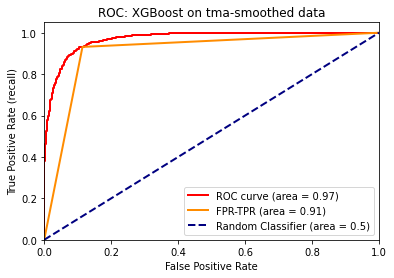

In [35]:
#Receiver Operating Characteristic (ROC), returns false positive rate (x-axis), true positive rate (y-axis)
fpr, tpr, _ = roc_curve(y_test_tma, y_pred)
roc_auc = auc(fpr, tpr)
print('FPR:',fpr[1].round(2))
print('TPR:',tpr[1].round(2))

lr_probs = y_pred_prob[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test_tma, lr_probs)
lr_roc_auc = auc(lr_fpr, lr_tpr)

lw = 2
plt.plot(lr_fpr, lr_tpr, linestyle='-', color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='FPR-TPR (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Classifier (area = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC: XGBoost on tma-smoothed data')
plt.legend(loc="lower right")
plt.show()

Average precision-recall score: 0.86


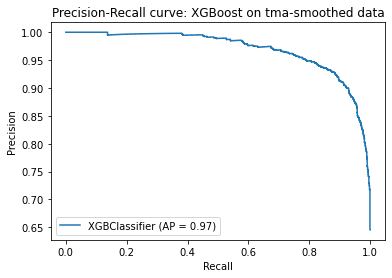

In [36]:
average_precision = average_precision_score(y_test_tma, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, X_test_scaled_tma, y_test_tma)
_=disp.ax_.set_title('Precision-Recall curve: XGBoost on tma-smoothed data')

### Tables of Results<a id='Table'></a>

|Model|Data (raw or tma)|Accuracy|F1-Score|Precision|Recall|Avg Precision|ROC AUC|Runtime|
|:-:|:-:|--:|--:|--:|--:|--:|--:|--:|
|RF (paper)|-|0.775|-|0.666|0.698|-|-|-|
|RF|raw|0.753|0.748|0.718|0.873|0.82|0.69|__2.526__|
|RF|tma|0.793|0.791|0.742|0.903|0.88|0.72|2.692|
|AdaBoost|raw|0.680|0.679|0.680|0.741|0.75|0.64|34.953|
|AdaBoost|tma|0.711|0.710|0.694|0.759|0.79|0.65|35.277|
|GradientBoost|raw|0.739|0.737|0.719|0.830|0.81|0.69|85.575|
|GradientBoost|tma|0.762|0.760|0.723|0.853|0.84|0.69|83.256|
|XGBoost|raw|0.864|0.863|0.836|0.922|0.94|0.81|4.655|
|__XGBoost__|tma|__0.894__|__0.893__|__0.875__|__0.920__|__0.96__|__0.84__|3.641|
|RF-optimized|tma|0.768|0.765|0.722|0.874|0.85|0.69|__0.528__|
|__XGBoost-optimized__|tma|__0.909__|__0.909__|__0.891__|__0.931__|__0.97__|__0.86__|32.856|

* For each metric, the top-two highest performing valued have been __bolded__ for ease of identification.
* RF (paper) results are from the following paper: http://ceur-ws.org/Vol-2429/paper6.pdf, and serve as a baseline for our modeling.

From our Table of Results, we notice the following:
* Random Forest (RF) and XG Boost (XGB) consistently outperform AdaBoost and GradientBoost.
* The TMA processed data consistently outperforms the Raw/Interpolated data.
    * This means that smoothing both the accelerometer data and TAC data prior to featurization has actually helped improve model performance.
    * Our baseline (out-of-the-box RF) with TMA-smoothed data has outperformed
* RF is consistently faster than XGB. This is especially true when XGB has a large number of n_estimators, as in XGBoost-optimized.
* RF-optimized (RF with hyperparameter tuning) performed worse than our out-of-the-box RF, except with regards to runtime, since RF-optimized used fewer n_estimators.

If we were simply looking at performance metrics such as accuracy and recall, XGBoost-optimized is the clear winner. However, it is computationally heavier than the other models (RF, out-of-the-box XGB). From this standpoint, our out-of-the-box XGB may actually be more promising, since it performs approximately 9 times faster than XGBoost-optimized, and still maintains a high accuracy (89.4%) and recall (92.0%).

### Feature Importance<a id='Feature'></a>

One more thing we should look at is feature importance. Decision Trees are generally interpretable, but Random Forests and Boosted trees can become more like a black box, where it is difficult to understand what is driving the model predictions. Luckily we can take a look at that and see what features play a large role in prediction, and which do not. The ones which contribute little to predictive power can be removed from the featurization process in the future, which could further save on resources.

We will look at the feature importances for our highest performing model (XGBoost-optimized), second-best performing model (XG Boost), and our fastest performing model (RF-optimized). All models were trained on the tma-smoothed data.

In [41]:
# Our last classifier, clf, was the XGBoost-optimized classifier. Rename is at xgb_opt
xgb_opt = clf
xgb_opt_feature_importance = xgb_opt.feature_importances_

#XGB trained on tma data
xgb_clf = xgb.XGBClassifier(seed=1)
xgb_clf.fit(X_train_scaled_tma, y_train_tma)
xgb_clf_feature_importance = xgb_clf.feature_importances_

#RF-optimized trained on tma data
rf_opt = RandomForestClassifier(n_estimators=69, 
                             min_samples_split = 12, 
                             min_samples_leaf= 1, 
                             max_depth = 21,
                             random_state = 1,
                             n_jobs=-1
                            )
rf_opt.fit(X_train_scaled_tma, y_train_tma)
rf_opt_feature_importance = rf_opt.feature_importances_

[15:38:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The top 20 most important features for XGB-Optimized.


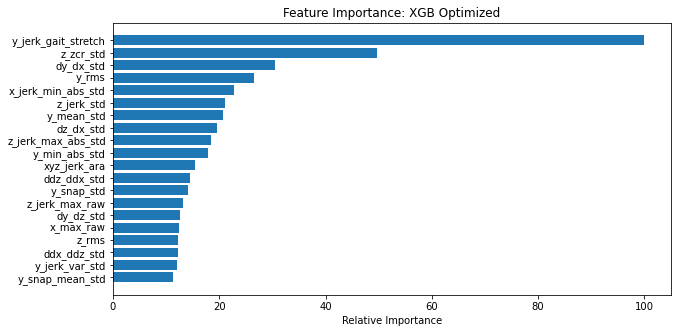

In [72]:
#XGB-optimized Feature Importance:

feature_importance = xgb_opt_feature_importance

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(-feature_importance)[:20] #negative makes argsort descending, and we select only the top 20 features

print('The top',sorted_idx.size,'most important features for XGB-Optimized.')

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_tma.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance: XGB Optimized')
plt.gca().invert_yaxis()

plt.show()

The top 20 most important features for XGB out-of-the-box.


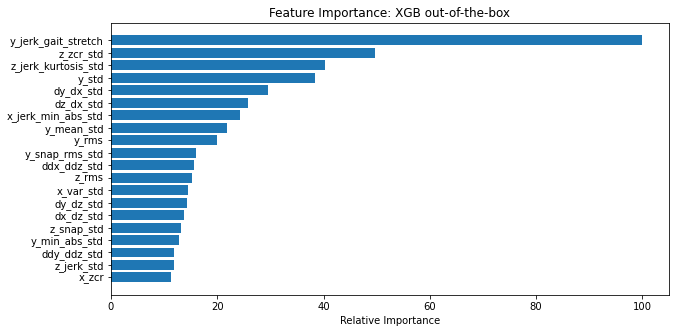

In [73]:
#XGB Feature Importance:

feature_importance = xgb_clf_feature_importance

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(-feature_importance)[:20]

print('The top',sorted_idx.size,'most important features for XGB out-of-the-box.')

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_tma.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance: XGB out-of-the-box')
plt.gca().invert_yaxis()

plt.show()

The top 20 most important features for RF-Optimized.


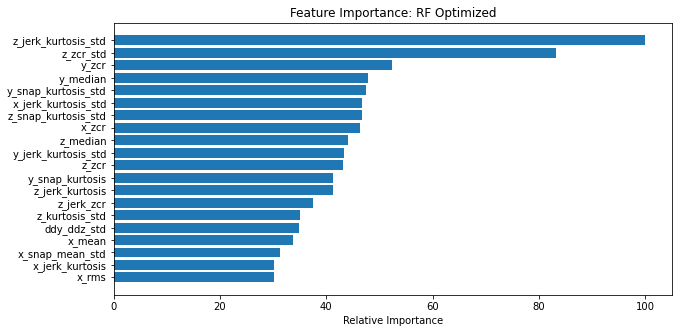

In [74]:
#RF-optimized Feature Importance:

feature_importance = rf_opt_feature_importance

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(-feature_importance)[:20]

print('The top',sorted_idx.size,'most important features for RF-Optimized.')

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_tma.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance: RF Optimized')
plt.gca().invert_yaxis()

plt.show()

In [77]:
#What about the least important features?

#XGB-optimized:
feature_importance = xgb_opt_feature_importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
n=10
sorted_idx = np.argsort(feature_importance)[:n] #leaving it positive makes argsort ascending

print('The bottom',n,'least important features for XGB-Optimized:')
print(X_train_tma.columns[sorted_idx])
print()


#XGB out-of-the-box:
feature_importance = xgb_clf_feature_importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[:n]
print('The bottom',n,'least important features for XGB out-of-the-box:')
print(X_train_tma.columns[sorted_idx])
print()

#RF-optimized:
feature_importance = rf_opt_feature_importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[:n]
print('The bottom',n,'least important features for RF-Optimized:')
print(X_train_tma.columns[sorted_idx])

The bottom 10 least important features for XGB-Optimized:
Index(['dy_dx', 'y_snap_var_std', 'ddy_ddx', 'z_var_std', 'ddz_ddx', 'z_var',
       'y_snap_step_time', 'y_snap_var', 'y_jerk_step_time',
       'x_jerk_step_time'],
      dtype='object')

The bottom 10 least important features for XGB out-of-the-box:
Index(['dy_dx', 'x_jerk_step_time', 'y_step_time', 'ddx_ddz', 'x_snap_var',
       'ddx_ddy', 'dz_dx', 'dx_dz', 'dx_dy', 'z_snap_step_time'],
      dtype='object')

The bottom 10 least important features for RF-Optimized:
Index(['z_snap_var', 'y_jerk_var', 'z_jerk_var', 'y_var', 'z_var', 'ddz_ddx',
       'z_snap_var_std', 'dx_dz', 'y_snap_var', 'dx_dy'],
      dtype='object')


#### Most Important Features

As expected, XGB and XGB-optimized are similar in their most important features. Several features that show up in both lists are:
* y_jerk_gait_stretch
* z_zcr_std
* dy_dx_std
* dy_dz_std
* dz_dx_std
* ddx_ddz_std
* x_jerk_min_abs_std
* z_jerk_std
* y_mean_std
* y_min_abs_std
* y_rms
* z_rms

3 of the 12 features listed above pertain to the standard deviation of another feature.

On the other hand, RF-optimized places more importance on a different set of features, though there are a few similarities to the XGB model.

Some features found to be top 20 most important for both XGB out-of-the-box and RF-optimized:
* z_zcr_std (found in all 3 models)
* z_jerk_kurtosis_std
* ddy_ddz_std
* x_zcr

For the top 20 features of all models, a significant portion of the top 20 features pertain to the standard deviation of another feature (14 of 20 for XGB-optimized, 16 of 20 for XGB, and 9 of 20 for RF-optimized). As we suspected in our previous notebooks (EDA and Preprocessing), there appeared to be more spread/variation in the "drunk" features compared to the "sober" featres, and indeed computing the standard deviation in our features has provided more predictive power to the model.

#### Least Important Features

As for the least important features, we see some commonalities between the 3 models in the bottom 10 least important features. Each of the following features shows up in the bottom-10 list of at least 2 of the 3 models:
* z_var
* y_snap_var
* ddz_ddx
* dx_dz
* dx_dy

We notice that none of these are standard deviations of features. 'var' is simply the variance, or square of the standard deviation, and therefore does not seem to add much to the model's predictive power. Other features like dx_dz, dx_dy (change in x over change in z, or change in x over change in y) is itself not useful, but the __standard deviation__ of those changes over a 10-second rolling window __is__ useful.

## 5.10 Summary and Next Steps<a id='5.10_Summary_and_Next_Steps'></a>

__Summary of the Notebook:__

* We applied 4 different Decision Tree Classifiers to model our dataset:
    * Random Forest Classifier
    * AdaBoost Classifier
    * GradientBoosting Classifier
    * XG Boost Classifier
* We found that RF and XGB using tma-smoothed data performed best in terms of accuracy, precision, recall, F1-score, ROC area-under-the-curve, and runtime compared to AdaBoost and GradientBoosting. These models also outperformed the RF classifier in the paper by the authors of the dataset. The authors acheived an accuracy of 77.5%, and both our out-of-the-box RF and XGB models achieved 
* We conducted hyperparameter tuning with 5-fold cross validation on the RF and XGB models.
* While XGB performed better than RF in all measured evaluation metrics, RF had the advantage of being faster.
* Calculating the Standard Deviation of other features was found to be useful in our models.
    * The most important features in our models were largely related to the standard deviation of other features (anywhere from 9 of 20 to 16 of 20 features were std-related).
    * The least important features in our models did not include standard deviations of other features.

Our most accurate model was our optimized XGB, with the following parameters: {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.1}. If resources were unlimited, this model could be used to develop an app that would predict when the user is no longer sober and can prompt them with a notification to curb heavy drinking behavior. If, however, we want to develop something lighter, we should instead use the out-of-the-box XGB (where 'n_estimators':100), which also performs well. And again, if we want to get even lighter, then we should look into Random Forest Classifiers as an option.


__Next Steps:__

If this model were to be implemented into a just-in-time drinking notification app, there is still room for improvement. We could do more hyperparameter tuning on the RF classifiers to improve its predictive power while keeping it light. We could also do the same with XGB Classifier, tuning it while keeping the n_estimators capped at 100 to avoid making the model heavier.

Alternative models that were not discussed here could also be looked into. Instead of randomly selecting data from each participant when preparing our training data, we could opt to preserve the datetime index and use it in combination with the features to predict blood alcohol content _ahead of time_, using forecasting methods like ARIMA or Facebook Prophet.

This concludes the coding portion of the project. We achieved the first deliverable: the code for a reliable classifier (RF, XGBoost, XGBoost-optimized, all trained on our TMA-smoothed data with features we developed ourselves). The remaining deliverables are the slide deck and the project report.